#### 다중 센서 변수 활용 테스트 데이터 

In [1]:
import pandas as pd

origin_data1 = pd.read_csv('data/CT1st_Case1.csv', encoding='cp949')
origin_data2 = pd.read_csv('data/CT1st_Case2.csv', encoding='cp949')

columns3132 = ["LD1 Temp", "LD2 Temp", "Meas?", "Glu2(mg/dl)", "LD_Bias_Av", "mPD1_dS", "T-rPD_L1dS", "R-rPD_L1dS", "mPD2_dS", "T-rPD_L2dS", "R-rPD_L2dS"]
columns_all = ["LD1 Temp", "LD2 Temp", "LD3 Temp", "Meas?", "Glu2(mg/dl)", "LD_Bias_Av", "mPD1_dS", "T-rPD_L1dS", "R-rPD_L1dS", "mPD2_dS", "T-rPD_L2dS", "R-rPD_L2dS", "mPD3_dS", "T-rPD_L3dS", "R-rPD_L3dS"]

data_R3132 = origin_data1[columns3132]
data_R3132 = data_R3132[data_R3132["Glu2(mg/dl)"] > 0]
data_R3132 = data_R3132[data_R3132["Meas?"] > 0]
data_R3132 = data_R3132.drop('Meas?', axis=1)
data_R3132 = data_R3132[data_R3132["mPD1_dS"] != 0]
data_R3132 = data_R3132[data_R3132["mPD2_dS"] != 0]

data_R_all = origin_data1[columns_all]
data_R_all = data_R_all[data_R_all["Glu2(mg/dl)"] > 0]
data_R_all = data_R_all[data_R_all["Meas?"] > 0]
data_R_all = data_R_all.drop('Meas?', axis=1)
data_R_all = data_R_all[data_R_all["mPD3_dS"] != 0]

In [2]:
import torch
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def preprocess(data , dt=False) -> tuple:
    if dt:
        data = data.astype({'Glu2(mg/dl)':'int'})
    
    X = data.drop('Glu2(mg/dl)', axis=1).values
    y = data['Glu2(mg/dl)'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return torch.tensor(X_train, dtype=torch.float32), \
        torch.tensor(y_train, dtype=torch.float32), \
        torch.tensor(X_test, dtype=torch.float32), \
        torch.tensor(y_test, dtype=torch.float32)

data_R3132_dt = preprocess(data_R3132, True)
data_R_all_dt = preprocess(data_R_all, True)

data_R3132 = preprocess(data_R3132, True)
data_R_all = preprocess(data_R_all)

In [3]:
from torch import onnx

def train_model(model, train_loader, num_epochs, learning_rate, name:str):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    epoch_losses = []
    for epoch in tqdm(range(num_epochs), desc=f'Train {name}'):
        total_loss = 0
        total_batches = 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            with torch.set_grad_enabled(True):
                y_hat = model(X)
                loss = criterion(y_hat.squeeze(), y)
                total_loss += loss.item()
                total_batches += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = total_loss / total_batches
        epoch_losses.append(epoch_loss)
    
    torch.save(model.state_dict(), f'property/{name}.pt')
    onnx.export(model, X.to(device), f'property/{name}.onnx')
    return epoch_losses

In [4]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 16
num_epochs = 100
learning_rate = 0.001

train_loader_R3132 = DataLoader(TensorDataset(data_R3132[0].unsqueeze(1), data_R3132[1]), batch_size=batch_size, shuffle=True)
train_loader_R_all = DataLoader(TensorDataset(data_R_all[0].unsqueeze(1), data_R_all[1]), batch_size=batch_size, shuffle=True)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from model import MLP, Conv1DModel, LinearRegressionModel

model_conv1d_R3132 = Conv1DModel(1, 2)
model_conv1d_R_all = Conv1DModel(1, 2)

losses_conv1d_R3132 = train_model(model_conv1d_R3132, train_loader_R3132, num_epochs, learning_rate, 'conv1d_R3132')
losses_conv1d_R_all = train_model(model_conv1d_R_all, train_loader_R_all, num_epochs, learning_rate, 'conv1d_R_all')

model_mlp_R3132 = MLP(9)
model_mlp_R_all = MLP(13)

losses_mlp_R3132 = train_model(model_mlp_R3132, train_loader_R3132, num_epochs, learning_rate, 'mlp_R3132')
losses_mlp_R_all = train_model(model_mlp_R_all, train_loader_R_all, num_epochs, learning_rate, 'mlp_R_all')

Train conv1d_R3132: 100%|████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]
C:\Work\CGM\ETRI_CGM_Analysis_ModelDev\JaeseongArea\model\_1d_conv_net.py:28: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x = functional.avg_pool1d(x, kernel_size=int(x.size(dim=2)))
Train mlp_R_all: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


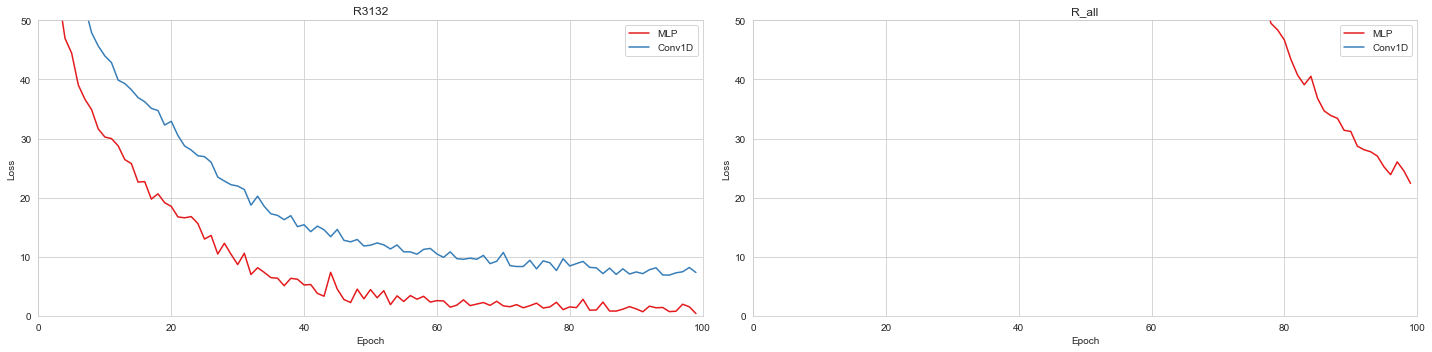

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(losses_mlp_R3132, label='MLP')
ax1.plot(losses_conv1d_R3132, label='Conv1D')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('R3132')
ax1.set_ylim(0, 50)
ax1.set_xlim(0, num_epochs)

ax2.plot(losses_mlp_R_all, label='MLP')
ax2.plot(losses_conv1d_R_all, label='Conv1D')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('R_all')
ax2.set_ylim(0, 50)
ax2.set_xlim(0, num_epochs)

plt.tight_layout()
plt.show()

#### 혼합데이터 MLP, Conv1d의 R2 Score

In [ ]:
import numpy

sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(20, 10))

y_pred, y_true, rms, r2 = model_infer(model_mlp_R31, train_loader_R31)
append_graph(ax1[0], y_true, y_pred, 'MLP R31')

y_pred, y_true, rms, r2 = model_infer(model_conv1d_R31, train_loader_R31)
append_graph(ax1[1], y_true, y_pred, 'Conv1d R31')


y_pred, y_true, rms, r2 = model_infer(model_mlp_R32, train_loader_R32)
append_graph(ax2[0], y_true, y_pred, 'MLP R32')

y_pred, y_true, rms, r2 = model_infer(model_conv1d_R32, train_loader_R32)
append_graph(ax2[1], y_true, y_pred, 'Conv1d R32')


y_pred, y_true, rms, r2 = model_infer(model_mlp_R21, train_loader_R21)
append_graph(ax3[0], y_true, y_pred, 'MLP R21')

y_pred, y_true, rms, r2 = model_infer(model_conv1d_R21, train_loader_R21)
append_graph(ax3[1], y_true, y_pred, 'Conv1d R21')


plt.tight_layout()
plt.show()

In [7]:
RF_R3132 = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=0)
GBM_R3132 = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=0)

RF_R_all = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=0)
GBM_R_all = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=0)

RF_R_allp = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=0)
GBM_R_allp = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=0)

num_epochs = 3

for epoch in tqdm(range(num_epochs), desc=f'Train {str}'):
    RF_R3132.fit(data_R3132_dt[0], data_R3132_dt[1])
    GBM_R3132.fit(data_R3132_dt[0], data_R3132_dt[1])
    
    RF_R_all.fit(data_R_all_dt[0], data_R_all_dt[1])
    GBM_R_all.fit(data_R_all_dt[0], data_R_all_dt[1])


Train <class 'str'>: 100%|███████████████████████████████████████████████████████████████| 3/3 [02:05<00:00, 41.78s/it]


In [8]:
print(RF_R3132.score(data_R3132_dt[2], data_R3132_dt[3]))
print(GBM_R3132.score(data_R3132_dt[2], data_R3132_dt[3]))

print(RF_R_all.score(data_R_all_dt[2], data_R_all_dt[3]))
print(GBM_R_all.score(data_R_all_dt[2], data_R_all_dt[3]))

0.9944211994421199
0.9919804741980475
0.2962962962962963
0.18518518518518517


#### Decision Tree에 대한 R2 Score

In [14]:
import numpy
from sklearn.metrics import mean_squared_error, r2_score

def model_infer(model, loder) -> tuple:
    y_pred = []
    y_true = []

    for X, y in loder:
        y_hat = model.predict(X.squeeze(0).tolist()) # model(X)
        y_hat = torch.Tensor(y_hat)
        y_pred.append(y_hat.cpu().numpy())
        y_true.append(y.cpu().numpy())
        
    y_pred = numpy.concatenate(y_pred)
    y_true = numpy.concatenate(y_true)
    rms = numpy.sqrt(mean_squared_error(y_true, y_pred.squeeze()))
    r2 = r2_score(y_true, y_pred.squeeze())
    return y_pred, y_true, rms, r2

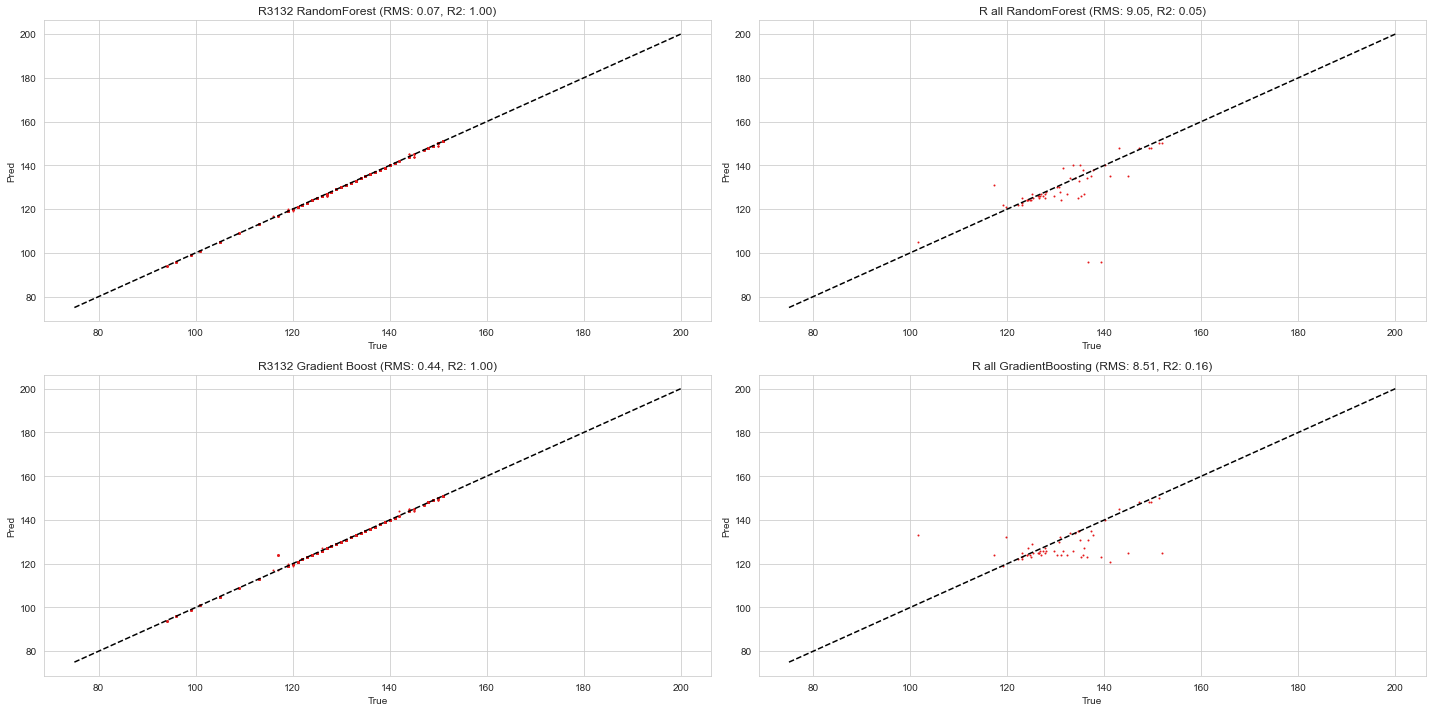

In [15]:
test_loader_R3132 = DataLoader(TensorDataset(data_R3132[2].unsqueeze(1), data_R3132[3]), batch_size=1, shuffle=True)
test_loader_R_all = DataLoader(TensorDataset(data_R_all[2].unsqueeze(1), data_R_all[3]), batch_size=1, shuffle=True)

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20, 10)) # RF, GB
y_pred, y_true, rms, r2 = model_infer(RF_R3132, test_loader_R3132)
ax1[0].scatter(y_true, y_pred, s=1, label='RandomForest R3132')
ax1[0].plot([75, 200], [75, 200], 'k--')
ax1[0].set_xlabel('True')
ax1[0].set_ylabel('Pred')
ax1[0].set_title(f'R3132 RandomForest (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(RF_R_all, test_loader_R_all)
ax1[1].scatter(y_true, y_pred, s=1, label='RandomForest R all')
ax1[1].plot([75, 200], [75, 200], 'k--')
ax1[1].set_xlabel('True')
ax1[1].set_ylabel('Pred')
ax1[1].set_title(f'R all RandomForest (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(GBM_R3132, test_loader_R3132)
ax2[0].scatter(y_true, y_pred, s=1, label='GBM R3132')
ax2[0].plot([75, 200], [75, 200], 'k--')
ax2[0].set_xlabel('True')
ax2[0].set_ylabel('Pred')
ax2[0].set_title(f'R3132 Gradient Boost (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(GBM_R_all, test_loader_R_all)
ax2[1].scatter(y_true, y_pred, s=1, label='GradientBoosting R all')
ax2[1].plot([75, 200], [75, 200], 'k--')
ax2[1].set_xlabel('True')
ax2[1].set_ylabel('Pred')
ax2[1].set_title(f'R all GradientBoosting (RMS: {rms:.2f}, R2: {r2:.2f})')

plt.tight_layout()
plt.show()

In [ ]:
def make_result_sample(data, model, count):
    y_h = []; pred = []
    for i in range(0, count):
        y_h.append(data[3][i])
        
        result = model.predict([data[2][i].tolist()])
        pred.append(result)
    
    return y_h, pred

statistic_RF = pandas.DataFrame(columns=["RF3132_y","RF3132_pred", "RF_all_y","RF_all_pred"])
statistic_GBM = pandas.DataFrame(columns=["GBM3132_y","GBM3132_pred", "GBM_all_y","GBM_all_pred"])

statistic_RF["RF3132_y"], statistic_RF["RF3132_pred"] = make_result_sample(data_R3132_dt, RF_R3132, 5)
statistic_RF["RF_all_y"], statistic_RF["RF_all_pred"] = make_result_sample(data_R_all_dt, RF_R_all, 5)

statistic_RF

In [ ]:
statistic_GBM["GBM3132_y"], statistic_GBM["GBM3132_pred"] = make_result_sample(data_R3132_dt, GBM_R3132, 5)
statistic_GBM["GBM_all_y"], statistic_GBM["GBM_all_pred"] = make_result_sample(data_R_all_dt, GBM_R_all, 5)

statistic_GBM